<a href="https://colab.research.google.com/github/gno-lit/DSI/blob/main/Module%201/Twist_Challenge/Nutrition_Help.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module1 Twist Challenge

## Problem:
Imagine an app that different restaurants use as a platform for customers to buy and deliver food. Imagine having to type a particular type of food and having image results of the food types and direct links to the restaurant. This would save the time of going through each restaurant to find a particular type of food and also allow you to explore similar food types based on the image
## Training Data:
The Images are scraped using the Microsoft Azure Bing Image search API
## Pretrained Model:
Models used to test best performance on validation data are
1. ResNet18
2. ResNet50
3. EfficientDet

## GUI:
Gradio.io

#ML Life Cycle from Model to Production
<img src="https://github.com/fastai/fastbook/blob/master/images/drivetrain-approach.png?raw=1" id="drivetrain" caption="The Drivetrain Approach">

In [1]:
#Installing fastai and setting up fastbook
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 720 kB 21.6 MB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 189 kB 58.9 MB/s 
     |████████████████████████████████| 1.2 MB 55.2 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 302 kB/s 
Mounted at /content/gdrive


# Scraping the web for images using Azure Image Search API
Download images with Bing Image Search api

In [2]:
# key is subscription key gotten from https://api.bing.microsoft.com/
key = os.environ.get('AZURE_SEARCH_KEY', '9644811521004683b733db9c9110e4d6')

In [3]:
# search_images_bing is a

results = search_images_bing(key, 'cooked rice')
ims = results.attrgot('contentUrl')
len(ims)

150

The results can change over time

Looking at one image:

In [4]:
dest = 'images/rice.jpg'
download_url(ims[0], dest)

Path('images/rice.jpg')

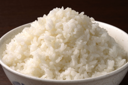

In [5]:
im = Image.open(dest)
im.to_thumb(128,128)

Using fastai's `download_images` to download all the URLs for each of our search terms and putting each in a separate folder:

In [6]:
meal_types = 'rice and stew','white rice','Jollof rice','Jollof Beans'
path = Path('meal')

In [7]:
if not path.exists():
    path.mkdir()
    for o in meal_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))


In [8]:
# Checking to see if folder has image files
fns = get_image_files(path)
fns

(#577) [Path('meal/Jollof Beans/00000102.JPG'),Path('meal/Jollof Beans/00000068.jpg'),Path('meal/Jollof Beans/00000111.jpg'),Path('meal/Jollof Beans/00000090.jpg'),Path('meal/Jollof Beans/00000089.jpg'),Path('meal/Jollof Beans/00000057.jpeg'),Path('meal/Jollof Beans/00000049.JPG'),Path('meal/Jollof Beans/00000031.jpg'),Path('meal/Jollof Beans/00000011.jpg'),Path('meal/Jollof Beans/00000009.JPG')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [9]:
# Verify_images returns an object of type L, which includes the map method. This calls the passed function on each element of the collection:
failed = verify_images(fns)
failed
# Use unlink to remove all the failed images, you can  on each of them
failed.map(Path.unlink);

Now that we have downloaded some data, we need to assemble it in a format suitable for model training. In fastai, that means creating an object called `DataLoaders`.

## From Data to DataLoaders

`DataLoaders` stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. 


To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

So far we have seen a number of *factory methods* for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the *data block API*. With this API you can fully customize every stage of the creation of your `DataLoaders`. Here is what we need to create a `DataLoaders` for the dataset that we just downloaded:

In [10]:
meals = DataBlock(
    #we specify what types we want for the independent and dependent variables
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    #parent_label is a function provided by fastai that simply gets the name of the folder a file is in
    get_y=parent_label,
    item_tfms=Resize(128))

In [11]:
dls = meals.dataloaders(path)

Trying different transforms to the image

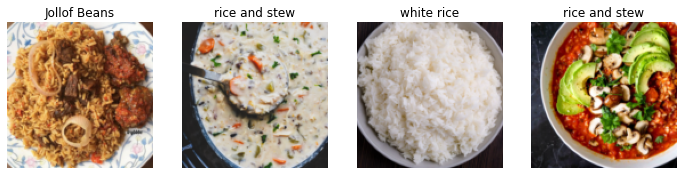

In [12]:
dls.valid.show_batch(max_n=4, nrows=1)

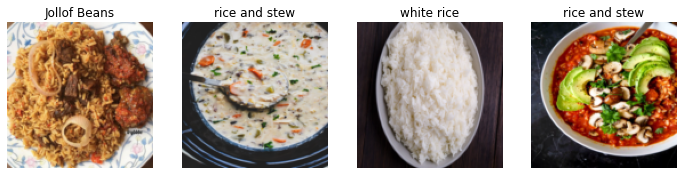

In [13]:
meals = meals.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = meals.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

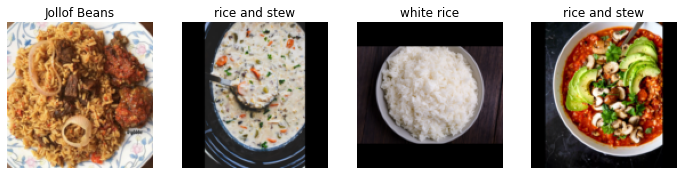

In [14]:
meals = meals.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = meals.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

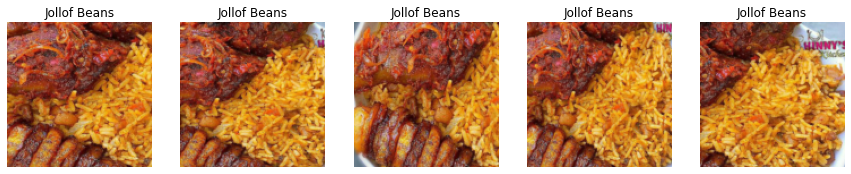

In [15]:
meals = meals.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = meals.dataloaders(path)
dls.train.show_batch(max_n=5, nrows=1, unique=True)

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

### Data Augmentation

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


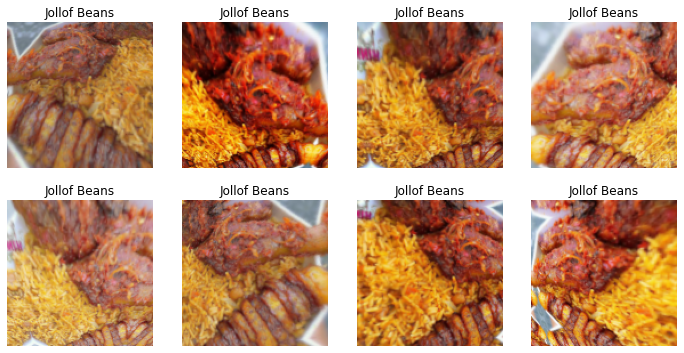

In [16]:
# aug_transforms returns a list of different augumentations
meals = meals.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = meals.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training The Model

In [18]:
meals = meals.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = meals.dataloaders(path)

In [19]:
#Creating the Learner and fine-tuning it:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.066074,1.432879,0.508772,02:03


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.291624,1.023026,0.377193,02:36
1,1.162256,0.928865,0.271930,02:38
2,1.017964,0.883039,0.271930,02:37
3,0.911688,0.866052,0.263158,02:36


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

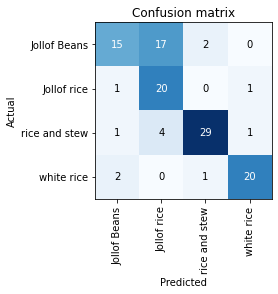

In [20]:
#Visualizing the Models confusion Matrix on the data
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It does quite good with most images but confuses beans with rice, next steps will be to try correcting that by viewing top losses and cleaning 

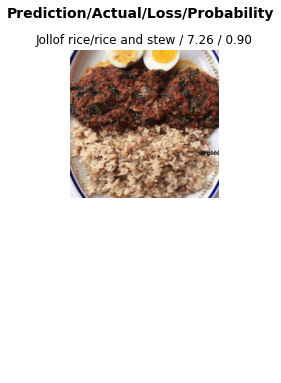

In [21]:
interp.plot_top_losses(1, nrows=2)

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [22]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [23]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Model Deployment

### Using the Model for Inference

In [24]:
#export would return save a file called "export.pkl which saves both the model architecture, parameter and pipeline for creating dataloaders
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
learn_inf = load_learner(path/'export.pkl')

In [27]:
#Pass a filename to predict to get predictions for one image at a time 
learn_inf.predict('images/rice.jpg')

('white rice',
 TensorBase(3),
 TensorBase([2.2208e-07, 1.2990e-06, 7.7747e-05, 9.9992e-01]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [28]:
learn_inf.dls.vocab

['Jollof Beans', 'Jollof rice', 'rice and stew', 'white rice']

Installing gradio and deploying Model

In [29]:
!pip install gradio

     |████████████████████████████████| 871 kB 11.7 MB/s 
     |████████████████████████████████| 210 kB 44.2 MB/s 
     |████████████████████████████████| 2.0 MB 49.6 MB/s 
     |████████████████████████████████| 52 kB 713 kB/s 
     |████████████████████████████████| 1.1 MB 49.9 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 144 kB 41.4 MB/s 
     |████████████████████████████████| 271 kB 56.3 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 10.9 MB 37.0 MB/s 
     |████████████████████████████████| 58 kB 3.0 MB/s 
     |████████████████████████████████| 79 kB 4.9 MB/s 
     |████████████████████████████████| 3.6 MB 39.2 MB/s 
     |████████████████████████████████| 61 kB 370 kB/s 
     |████████████████████████████████| 856 kB 50.8 MB/s 
     |████████████████████████████████| 58 kB 4.9 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=f1e

In [30]:
import gradio as gr
import tensorflow as tf
import numpy as np
import json
from os.path import dirname, realpath, join

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
pwd

'/content'

In [34]:
# Load human-readable labels for ImageNet.
labels_file= open('../Labels.json')
labels = json.load(labels_file)

In [35]:
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn_inf.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [36]:
gr_interface = gr.Interface(fn=predict, 
                            inputs=gr.inputs.Image(shape=(512, 512)),
                            outputs=gr.outputs.Label(num_top_classes=len(labels)),
                            capture_session=True,
                            interpretation="default",
                            examples=[
                                      ["images/rice.jpg"]
                                      ])
gr_interface.launch()

/usr/local/lib/python3.7/dist-packages/gradio/interface.py:224: UserWarning: The `capture_session` parameter in the `Interface` is deprecated and may be removed in the future.
  "The `capture_session` parameter in the `Interface`"


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://47987.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f28b55682d0>,
 'http://127.0.0.1:7860/',
 'https://47987.gradio.app')